### Make necessary imports

## Exploration for Claim 2: ##
    Having porch or deck increases home sale price

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms

%matplotlib inline
plt.style.use('ggplot')

#from ltests import model

### Import our combined csv into a DataFrame

In [2]:
raw = pd.read_csv('../../data/master.csv', low_memory=False, dtype={'id': object})

In [3]:
#how many entries are there?
raw.shape[0]

62039

### We would like to select only those entries that have a sale price greater than 0

In [4]:
raw = raw[raw.SalePrice > 0]
raw.shape[0]

42214

### Now we select the sales with the proper PropertyType codes
The following are of interest to us:
 - 11: Household, single family units
 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums
  
*These codes can be found in the Lookup.zip file located at*

https://info.kingcounty.gov/assessor/DataDownload/default.aspx 

In [5]:
proptypes = [11]

df = raw[raw.PropertyType.isin(proptypes)]
df.shape[0]


19264

In [6]:
#add column to dataframe OutdoorSpace
df['OutdoorSpace']= df['SqFtOpenPorch']+df['SqFtEnclosedPorch']+df['SqFtDeck']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df.shape[0]

19264

In [8]:
#filling in NaN with zero
#assuming they are NaN because there is no porch or deck
df['OutdoorSpace'] = df['OutdoorSpace'].fillna(0)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df.shape[0]

19264

### Generate our first simple model of Sale Price vs TOutdoorSpace

In [10]:
fsm_df = df[["SalePrice", "SqFtOpenPorch", "SqFtEnclosedPorch", "SqFtDeck"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtOpenPorch+SqFtEnclosedPorch+SqFtDeck'
fsm = ols(formula=formula, data=fsm_df).fit()

Let's see that big table

In [11]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     867.8
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:33:42   Log-Likelihood:            -2.7541e+05
No. Observations:               18807   AIC:                         5.508e+05
Df Residuals:                   18803   BIC:                         5.509e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.352e+05   5235.881    121.320      0.000    6.25e+05    6.45e+05
SqFtOpenPorch      1103.7860     26.887     41.053      0.000    1051.085    1156.486
SqFtEnclosedPorch   131.4391    110.018      1.195      0.232     -84.207     347.085
SqFtDeck            583.4571     18.950     30.789      0.000     546.313     620.601
==============================================================================
Omnibus:                    21676.344   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8589665.246
Skew:                           5.528   Prob(JB):                         0.00
Kurtosis:                     107.112   Cond. No.                         335.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
fsm_df.shape[0]

18807

## Check homoscedasticity

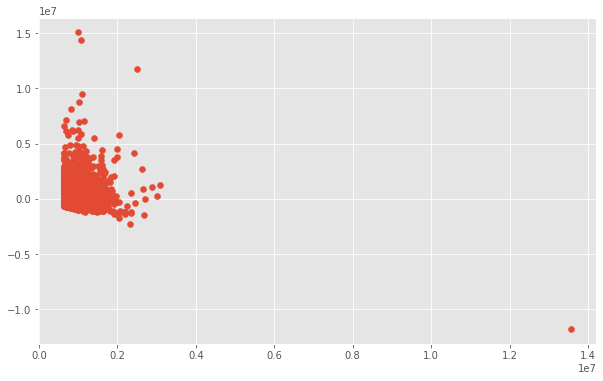

In [13]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);

## check normality with Q-Q plot

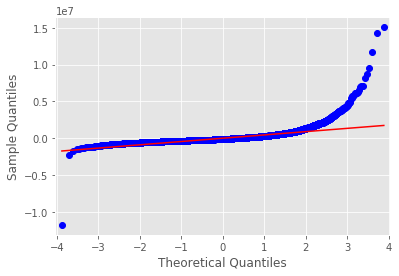

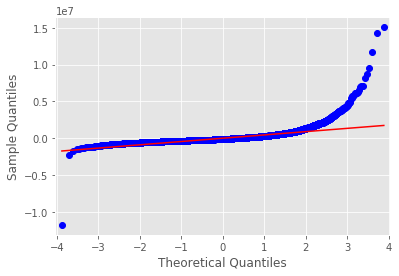

In [14]:
sm.qqplot(fsm_resids, line='r')

## check normality with Jarque Bera test

In [15]:
name = ['JB', 'Prob', 'Skew', 'Kurtosis']
test = sms.jarque_bera(fsm.resid)
list(zip(name, test))

[('JB', 8589665.245872445),
 ('Prob', 0.0),
 ('Skew', 5.528110678458962),
 ('Kurtosis', 107.11152039972919)]

### Let's try do drop some outliers 

let's remove elements with a z-score outsize of [-3,3] in either the sale price or the square foot columns

In [16]:
from scipy import stats
ssm_df = fsm_df[(np.abs(stats.zscore(fsm_df)) < 3).all(axis=1)]

In [17]:
formula = 'SalePrice ~ SqFtOpenPorch+SqFtEnclosedPorch+SqFtDeck'
ssm = ols(formula=formula, data=ssm_df).fit()

In [18]:
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     728.7
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:34:01   Log-Likelihood:            -2.5145e+05
No. Observations:               17697   AIC:                         5.029e+05
Df Residuals:                   17693   BIC:                         5.029e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.107e+05   3840.382    159.023      0.000    6.03e+05    6.18e+05
SqFtOpenPorch      1149.7487     28.904     39.778      0.000    1093.094    1206.404
SqFtEnclosedPorch  -400.4997    232.807     -1.720      0.085    -856.824      55.824
SqFtDeck            436.3984     15.967     27.331      0.000     405.101     467.696
==============================================================================
Omnibus:                     4745.176   Durbin-Watson:                   0.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13013.932
Skew:                           1.430   Prob(JB):                         0.00
Kurtosis:                       6.078   Cond. No.                         298.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check homoscedasticity again

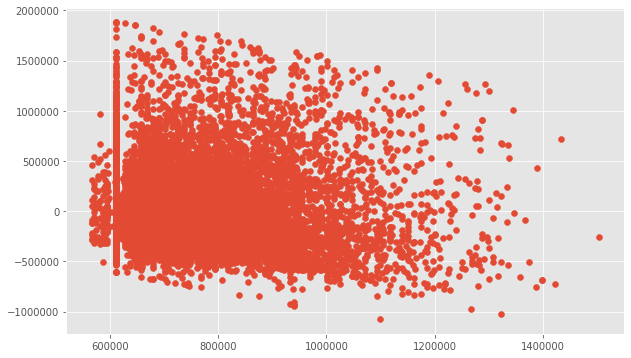

In [19]:
ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

## check normality with Q-Q plot again

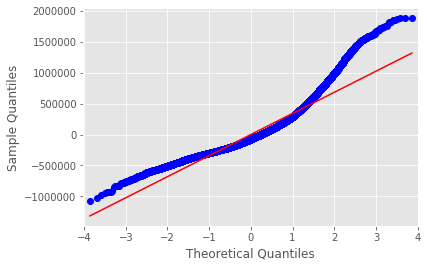

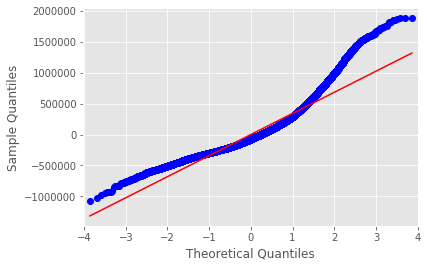

In [20]:
sm.qqplot(ssm_resids, line='r')

## check normality with Jarque Bera test again

In [21]:
name = ['JB', 'Prob', 'Skew', 'Kurtosis']
test = sms.jarque_bera(ssm.resid)
list(zip(name, test))

[('JB', 13013.931950667877),
 ('Prob', 0.0),
 ('Skew', 1.4295965450085415),
 ('Kurtosis', 6.0779888977541)]

## Check means of populations houses with and without porch/deck

In [22]:
df['OutdoorSpace'].describe()

count    19264.000000
mean       210.701464
std        261.106145
min          0.000000
25%         30.000000
50%        130.000000
75%        300.000000
max      11850.000000
Name: OutdoorSpace, dtype: float64

In [23]:
df['OutdoorSpace'].isnull().sum()

0

In [33]:
#create dataframe with OutdoorSpace greater than zero... 
# meaning these are houses with a porch or deck
porch = df[df.OutdoorSpace > 0]
# how many 
a=porch.shape[0]
print(a)

14672


In [25]:
no_porch = df[df.OutdoorSpace == 0] 
b=no_porch.shape[0]
print(b)

4592


In [26]:
print(a+b)

19264


In [27]:
alt = porch.SalePrice.values

In [28]:
control = no_porch.SalePrice.values

In [31]:
alt.mean(), control.mean()

(846473.3075926936, 628407.5222125435)

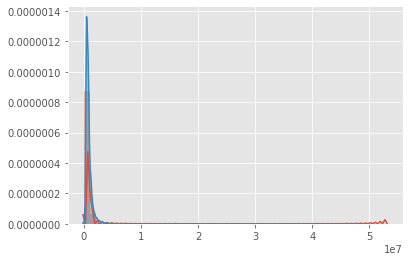

In [29]:
sns.distplot(control)
sns.distplot(alt)


In [30]:
from scipy.stats import ttest_ind
critical_tstat = stats.t.ppf(.95, 21479)

ttest_result=ttest_ind(control, alt)
print(f'critical t_stat: {critical_tstat}')
print(f'test t-stat: {ttest_result.statistic}')
print(f'pvalue = {ttest_result.pvalue/2}')

critical t_stat: 1.6449245723060157
test t-stat: -18.54118065283717
pvalue = 2.207030074493875e-76
